<h1>Collecting Data from Archived Websites</h1>

<p>In this section, we collect data from archived websites using a query term and a specified range of years (2010-2022). We are using the <strong>Arquivo.pt</strong> service to fetch historical search results from specific Portuguese websites.</p>

<h2>Step 1: Importing Libraries</h2>

<p>We first import the necessary libraries:</p>
<ul>
    <li><strong>pandas</strong>: For data manipulation.</li>
    <li><strong>requests</strong>: To send HTTP requests to websites and retrieve data.</li>
    <li><strong>BeautifulSoup</strong>: A library for parsing HTML (though not used in this code, it's typically useful for web scraping).</li>
    <li><strong>urllib.parse</strong>: For URL parsing.</li>
    <li><strong>newspaper</strong>: A Python library for extracting articles (though not used here, it can be useful for article extraction from URLs).</li>
    <li><strong>json</strong>: For parsing JSON responses from APIs.</li>
</ul>

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import time
from newspaper import Article
import json

,anos,Tesla,carro elétrico,Renault Zoe,emissão zero,mobilidade sustentável,poluição do ar
0,2010,0,0,0,0,0,0
1,2011,0,0,0,5,0,6
2,2012,1,0,0,11,0,7
3,2013,0,0,0,36,19,73
4,2014,78,47,0,103,9,452
5,2015,17580,6660,0,250,266,1992
6,2016,62888,14418,11128,2456,1468,16876
7,2017,113383,5858,28044,1518,1765,7688
8,2018,75352,20763,13389,1703,1883,4870
9,2019,42978,18578,7804,6156,8813,14241


<h2>Step 2: Defining the Function for Data Retrieval</h2>

<p>The function <code>resultados_por_ano</code> takes a <strong>query term</strong> as input and fetches the search result counts for that term across the years 2010 to 2022 from the <strong>Arquivo.pt</strong> API. We specify multiple Portuguese websites for the search, including <code>publico.pt</code>, <code>sapo.pt</code>, and others.</p>

In [ ]:
def resultados_por_ano(query_term):
    sites = 'publico.pt,sapo.pt,jn.pt,observador.pt,expresso.pt'

    resultados = []
    titulos = []
    for i in range(2010, 2023):
        data = [int(f"{i}0101"), int(f"{i}1231")]
        

        site= f"https://arquivo.pt/textsearch?q={query_term}&prettyPrint=false&from={data[0]}&to={data[1]}&siteSearch={sites}"
        # json = requests.get(site).json()["response_items"]
        content = requests.get(site).json()
        resultados.append(content['estimated_nr_results'])
        # print(f"{query_term}, {i}, ok", end=" | ")
        #try:
        #    print(json[0]["linkToExtractedText"])
        #except:
        #    pass

    return resultados

<h2>Step 3: Retrieving Results for Multiple Query Terms</h2>

<p>We define a <code>DataFrame</code> to store the results for each query term over the years 2010 to 2022. The query terms include terms related to electric cars and sustainability, such as "Tesla", "Renault Zoe", and "carro elétrico". For each term, we call the <code>resultados_por_ano</code> function and append the results to the DataFrame.</p>

In [ ]:
df = pd.DataFrame({"anos": list(range(2010, 2023))})
# Query terms to search for
query_terms = [
    "Tesla", "carro elétrico", "Renault Zoe",
    "emissão zero",
    "mobilidade sustentável","poluição do ar" 
    #"Tesla Model 3", "Tesla Model Y",
]
for term in query_terms:
    df[term] = resultados_por_ano(term)

df

<h2>Output</h2>

<p>The resulting <code>DataFrame</code> shows the number of search results for each query term across the years 2010 to 2022. The columns are as follows:</p>
<ul>
    <li><strong>anos</strong>: Years (2010-2022)</li>
    <li><strong>Query Terms</strong>: The number of results for each query term in each year.</li>
</ul>

<p>This table can be used for further analysis of trends related to each query term over the specified years.</p>

<h1>Web Scraping Articles from Arquivo.pt</h1>

<p>In this section, we are extracting article content from various Portuguese news websites through the <strong>Arquivo.pt</strong> API. The function uses the query term to retrieve articles published between 2010 and 2022. The extracted text is then saved for further analysis.</p>

<h2>Step 1: Extract Article Content</h2>

<p>The <code>extract_article_content</code> function downloads and parses the article from the provided URL using the <strong>newspaper3k</strong> library. It extracts the text content of the article for further analysis. If an error occurs while extracting the article, the function returns <code>None</code>.</p>

In [4]:
def extract_article_content(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        
        # return {
        #     "title": article.title,
        #     "text": article.text,
        #     "authors": article.authors,
        #     "publish_date": article.publish_date,
        #     "keywords": article.keywords if article.is_parsed else [],
        # }
        return article.text
    except Exception as e:
        print(f"Error extracting {url}: {e}")
        return None

Processing year 2010 for query 'Tesla'
No more items returned at offset 0. Stopping.
Processing year 2011 for query 'Tesla'
No more items returned at offset 0. Stopping.
Processing year 2012 for query 'Tesla'
Fetched 1 items at offset 1
Last page reached with 1 items.
Processing year 2013 for query 'Tesla'
No more items returned at offset 0. Stopping.
Processing year 2014 for query 'Tesla'
Fetched 53 items at offset 53
Last page reached with 53 items.
Processing year 2015 for query 'Tesla'
Fetched 500 items at offset 500
Fetched 229 items at offset 729
Last page reached with 229 items.
Processing year 2016 for query 'Tesla'
Fetched 500 items at offset 500
Fetched 500 items at offset 1000
Fetched 500 items at offset 1500
Fetched 465 items at offset 1965
Last page reached with 465 items.
Processing year 2017 for query 'Tesla'
Fetched 500 items at offset 500
Fetched 500 items at offset 1000
Fetched 500 items at offset 1500
Fetched 500 items at offset 2000
Fetched 1 items at offset 2001
La

,year,query_term,title,url,extracted_text
0,2014,Tesla,A Tesla vai instalar postos de super carregame...,https://arquivo.pt/noFrame/replay/201410230816...,"Em 2015, a Península Ibérica vai ter uma rede ..."
1,2014,Tesla,,https://arquivo.pt/noFrame/replay/201410230817...,O Governo tem até quarta-feira para entregar n...
2,2014,Tesla,Pedro Esteves - Observador,https://arquivo.pt/noFrame/replay/201410221351...,"Comecei a fazer Rádio em 1987, no tempo das ""p..."
3,2014,Tesla,Pedro Esteves - 2/10455 - Observador,https://arquivo.pt/noFrame/replay/201410221351...,"Comecei a fazer Rádio em 1987, no tempo das ""p..."
4,2014,Tesla,nanoFLOWCELL: uma nova tecnologia que promete ...,https://arquivo.pt/noFrame/replay/201412020223...,A empresa suíça nanoFLOWCELL desenvolveu um pr...


<h2>Step 2: Process Each Item</h2>

<p>The <code>process_item</code> function takes an item from the Arquivo.pt response, extracts the article content using the <code>extract_article_content</code> function, and then returns a dictionary with the article's details: year, query term, title, URL, and extracted text.</p>

In [ ]:
def process_item(item,query_term):
    linkToArchive = item.get('linkToNoFrame')
    extracted_text = extract_article_content(linkToArchive)
    
    if extracted_text:
        return {
            "year": item.get('date')[:4],  # Assuming date is in YYYYMMDD format
            "query_term": query_term,
            "title": item.get('title'),
            "url": linkToArchive,
            "extracted_text": extracted_text
        }
    else:
        return None

<h2>Step 3: Web Scraping Function</h2>

<p>The <code>webscrapping</code> function processes the data for each query term, sending requests to the Arquivo.pt API for each year from 2010 to 2022. The articles are fetched in batches, and the content is parsed and filtered. The results for each year and query term are saved as a JSON file.</p>

In [ ]:


# Function to get results from Arquivo.pt API and then filter by text content
def webscrapping(query_term):
    sites = 'publico.pt,sapo.pt,jn.pt,expresso.pt,observador.pt'
    textos_filtrados = []
    
    for i in range(2010, 2023):  # Loop through each year
        data = [int(f"{i}0101"), int(f"{i}1231")]
        offset = 0
        max_items = 500  # Maximum allowed per request

        print(f"Processing year {i} for query '{query_term}'")

        while True:

            site = f"https://arquivo.pt/textsearch?q={query_term}&prettyPrint=false&from={data[0]}&to={data[1]}&siteSearch={sites}&offset={offset}&maxItems={max_items}"
        
            try:
                response = requests.get(site)
                
                # Check if the response status is OK
                if response.status_code != 200:
                    print(f"Received HTTP {response.status_code} for year {i}, query '{query_term}' at offset {offset}. Skipping to next year.")
                    break  # Break the while loop and proceed to the next year

                try:
                    content = response.json()
                except ValueError as ve:
                    print(f"Error parsing JSON for year {i}, query '{query_term}' at offset {offset}: {ve}")
                    break  # Break the while loop and proceed to the next year

                items = content.get('response_items', [])
                
                for item in items:
                    linkToArchive = item.get('linkToNoFrame')
                    if not linkToArchive:
                        continue  # Skip if the link is missing

                    extracted_text = extract_article_content(linkToArchive)
                    
                    if extracted_text:
                        textos_filtrados.append({
                            "year": i,
                            "query_term": query_term,
                            "title": item.get('title', ''),
                            "url": linkToArchive,
                            "extracted_text": extracted_text
                        })

                if not items:
                    print(f"No more items returned at offset {offset}. Stopping.")
                    break 


                items_fetched = len(items)
                offset += items_fetched
                print(f"Fetched {items_fetched} items at offset {offset}")
                
                # Optional delay to respect rate limits
                time.sleep(1)

                # If fewer items are returned than max_items, we've reached the last page
                if items_fetched < max_items:
                    print(f"Last page reached with {items_fetched} items.")
                    break

            except Exception as e:
                print(f"Error processing year {i} for query {query_term}: {e}")
        # After processing each year
        with open(f"textos_filtrados_{query_term}_{i}.json", "w", encoding='utf-8') as f:
            json.dump(textos_filtrados, f, ensure_ascii=False, indent=4)
        
    return textos_filtrados


<h2>Step 4: Collecting Data for Multiple Query Terms</h2>

<p>We loop through the list of query terms to collect articles for each term over the years 2010 to 2022. After the scraping is complete, we store the results in a DataFrame and save them as CSV files for further analysis.</p>

In [ ]:
# Query terms to search for
query_terms = [
    "Tesla", "carro elétrico", "Renault Zoe",
    "emissão zero",
    "mobilidade sustentável","poluição do ar" 
    #"Tesla Model 3", "Tesla Model Y",
]

# Dictionary to store filtered texts for each query
filtered_texts = []

# Loop through each query term and collect data
for term in query_terms:
    textos_filtrados = webscrapping(term)
    filtered_texts.extend(textos_filtrados)
    print(f"Finished processing {term}")

# Convert the filtered texts into a DataFrame
df_articles = pd.DataFrame(filtered_texts)

# Grouping by year and query term to count the number of articles per year for each term
df_article_counts = df_articles.groupby(["year", "query_term"]).size().unstack(fill_value=0)

# Display the article count DataFrame (one column per query term, one row per year)
print(df_article_counts)

# Save the articles DataFrame to CSV for future analysis if needed
df_articles.to_csv("extracted_articlesv4.csv", index=False)

# Save the article counts to another CSV
df_article_counts.to_csv("article_counts_by_yearv4.csv")

df_articles.head()

<h2>Output</h2>

<p>The <code>df_articles</code> DataFrame contains the articles collected for each query term and year. The <code>df_article_counts</code> DataFrame shows the number of articles retrieved for each query term per year.</p>

<h1>Data Cleaning and Text Processing for Articles</h1>

<p>This section focuses on cleaning and processing the article data collected earlier. The goal is to ensure that the data is consistent, meaningful, and ready for analysis. The steps include:</p>

<ul>
    <li>Handling missing values and duplicates</li>
    <li>Cleaning and preprocessing text</li>
    <li>Removing stopwords and lemmatizing the text</li>
    <li>Extracting keywords</li>
    <li>Calculating relevance scores based on query terms</li>
</ul>

<h2>Step 1: Load and Combine Data</h2>

<p>The first step is to load all the JSON files from the specified directory and combine them into a single DataFrame.</p>

In [42]:
import pandas as pd
import glob
import os
import json

# Define the directory where your CSV files are stored
data_directory = 'Filtered-Texts'

all_files = glob.glob(os.path.join(data_directory, "textos_filtrados_*.json"))

df_list = []

for file in all_files:
    with open(file, "r", encoding='utf-8') as f:
        data = json.load(f)
        df_list.append(pd.DataFrame(data))

df_combined = pd.concat(df_list, ignore_index=True)

print(f"Total number of articles before cleaning: {len(df_combined)}")


Total number of articles before cleaning: 176412


<h2>Step 2: Handle Missing Values and Duplicates</h2>

<p>Next, we check for missing values and remove rows where the 'extracted_text' column is missing. We also remove duplicate articles based on the 'url' and 'title'.</p>

In [44]:
# Check for missing values
missing_values = df_combined.isnull().sum()
print("Missing values before cleaning:")
print(missing_values)

# Drop rows where 'extracted_text' is missing or empty
df_cleaned = df_combined.dropna(subset=['extracted_text'])

print(f"Total number of articles after dropping missing texts: {len(df_cleaned)}")

# Remove duplicates based on 'url'
df_cleaned = df_cleaned.drop_duplicates(subset='url')
df_cleaned = df_cleaned.drop_duplicates(subset='title')
df_cleaned = df_cleaned.reset_index(drop=True)
print(f"Total number of articles after removing duplicates: {len(df_cleaned)}")

Missing values before cleaning:
year              0
query_term        0
title             0
url               0
extracted_text    0
dtype: int64
Total number of articles after dropping missing texts: 176412
Total number of articles after removing duplicates: 22301


<h2>Step 3: Text Cleaning and Preprocessing</h2>

<p>We clean the text by removing HTML tags, URLs, numbers, and non-alphabetic characters. The text is also converted to lowercase, and extra spaces are removed.</p>

In [2]:
import re
import string

# Enhanced Cleaning Function
def clean_text_spacy(text):
    if not isinstance(text, str):
        return ''
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove non-alphabetic characters (retain spaces and accented characters)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply the cleaning function to 'extracted_text' and 'title'
df_cleaned['cleaned_text'] = df_cleaned['extracted_text'].apply(clean_text_spacy)
df_cleaned['cleaned_title'] = df_cleaned['title'].apply(clean_text_spacy)

<h2>Step 4: Tokenization, Lemmatization, and Stopwords Removal</h2>

<p>We tokenize the text, remove stopwords, and perform lemmatization using the <strong>spaCy</strong> library. Custom stopwords are loaded from external files to ensure comprehensive filtering.</p>

In [3]:
import spacy
from collections import Counter
import csv
import re

# Load the Portuguese model
nlp = spacy.load('pt_core_news_lg')
# Check if the vectors are loaded
if nlp.vocab.vectors:
    print("Word vectors are loaded!")
else:
    print("No word vectors available.")

# Load stop phrases from a file
stop_phrases_file = 'stop_phrases.txt'  # Path to your file
with open(stop_phrases_file, 'r', encoding='utf-8') as file:
    stop_phrases = [line.strip().lower() for line in file if line.strip()]

stopwords_file = 'stopwords.txt'  # Update the path if necessary
with open(stopwords_file, 'r', encoding='utf-8') as file:
    custom_stopwords = [line.strip().lower() for line in file if line.strip()]

for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word.lower())  # Ensure all stopwords are lowercase
    nlp.vocab[word.lower()].is_stop = True  # Mark the word as a stopword in the vocabulary


def tokenize_remove_stopwords_lemmatize(text, stop_phrases):
    # Step 1: Remove multi-word phrases
    for phrase in stop_phrases:
        text = re.sub(r'\b' + re.escape(phrase) + r'\b', '', text, flags=re.IGNORECASE)

    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and token.is_alpha
        and len(token.text) > 1  # Exclude single-letter tokens
    ]
    return tokens

# Tokenize and remove stopwords
df_cleaned['tokens'] = df_cleaned['cleaned_text'].apply(
    lambda text: tokenize_remove_stopwords_lemmatize(text, stop_phrases)
)
df_cleaned = df_cleaned[df_cleaned['tokens'].apply(len) > 10]

print("tokens")    

Word vectors are loaded!
tokens
keywords
lemmatized_text
['Tesla', 'carro', 'elétrico', 'Renault', 'Zoe', 'emissão', 'zero', 'mobilidade', 'sustentável', 'poluição', 'ar']
Total number of articles after filtering by query terms: 6182
Data cleaning complete. Cleaned data saved to 'cleaned_articles_spacy7.csv'


<h2>Step 5: Keyword Extraction and Relevance Calculation</h2>

<p>We extract the most frequent keywords from the cleaned text and calculate the relevance score based on a list of query terms. The relevance score indicates how closely an article matches the query terms.</p>


In [ ]:
def extract_keywords_spacy(tokens, top_n=10):
    # Frequency-based keyword extraction
    counter = Counter(tokens)
    common = counter.most_common(top_n)
    keywords = [word for word, freq in common]
    return keywords

# Function to check if any query term is in the text
def contains_query_terms(text, lemmatized_queries):
    # Tokenize the text into words (it's already lemmatized, so no need for further lemmatization)
    text_tokens = text.split()  # Assuming the text is a string of space-separated lemmatized tokens
    
    # Check if any query term exists in the lemmatized text tokens
    return any(query in text_tokens for query in lemmatized_queries)

# Function to calculate similarity
def calculate_relevance(doc_text, lemmatized_queries):
    if not doc_text or not lemmatized_queries:
        return 0  # Return 0 for empty inputs
    doc = nlp(doc_text)
    query_doc = nlp(" ".join(lemmatized_queries))
    return doc.similarity(query_doc)

# Extract keywords
df_cleaned['keywords'] = df_cleaned['tokens'].apply(lambda tokens: extract_keywords_spacy(tokens, top_n=10))
print("keywords")

df_cleaned['lemmatized_text'] = df_cleaned['tokens'].apply(lambda tokens: ' '.join(tokens))
print("lemmatized_text")

# Combine all unique query terms
query_terms = [
    "Tesla", "carro elétrico", "Renault Zoe",
    "emissão zero",
    "mobilidade sustentável","poluição ar" 
]
# Combine the list into a single string with each term separated by a space
query_terms_str = ' '.join(query_terms)
lemmatized_queries = [token.lemma_ for token in nlp(query_terms_str)]
print(lemmatized_queries)

# Filter articles that mention any query term
df_cleaned = df_cleaned[df_cleaned['lemmatized_text'].apply(lambda text: contains_query_terms(text, lemmatized_queries))]

# # Log the number of articles after filtering
print(f"Total number of articles after filtering by query terms: {len(df_cleaned)}")

# Calculate relevance score for each text
df_cleaned['relevance_score'] = df_cleaned['lemmatized_text'].apply(
    lambda text: calculate_relevance(text, lemmatized_queries)
)

threshold = 0.5  # Define the relevance threshold
df_filtered = df_cleaned[df_cleaned['relevance_score'] >= threshold]

# Reorder columns if necessary
desired_order = ['year','query_term', 'title', 'cleaned_title', 'url', 'extracted_text', 'cleaned_text', 'tokens', 'keywords','lemmatized_text', 'relevance_score']
df_filtered = df_filtered.reindex(columns=desired_order)

<h2>Step 6: Save Cleaned Data</h2>

<p>Finally, we save the cleaned articles into a CSV file and a JSON file. This allows for easy access and further analysis.</p>

In [ ]:
# Save the DataFrame with proper quoting
df_filtered.to_csv(
    'cleaned_articles_spacy7.csv',
    index=False,
    encoding='utf-8',
    quoting=csv.QUOTE_ALL  # Ensures that all fields are quoted
)

df_filtered.to_json('cleaned_articles_spacy7.json', orient='records', lines=True, force_ascii=False)

print("Data cleaning complete. Cleaned data saved to 'cleaned_articles_spacy7.csv'")

<h1>Data Visualization and Text Analysis</h1>

<p>This section focuses on visualizing the distribution of word counts, identifying the most frequent words, generating word clouds, and analyzing n-grams (bi-grams and tri-grams) in the articles.</p>

<h2>Step 1: Distribution of Word Counts</h2>

<p>The first visualization shows the distribution of the number of words in each article using a histogram. This helps us understand the general length of the articles.</p>

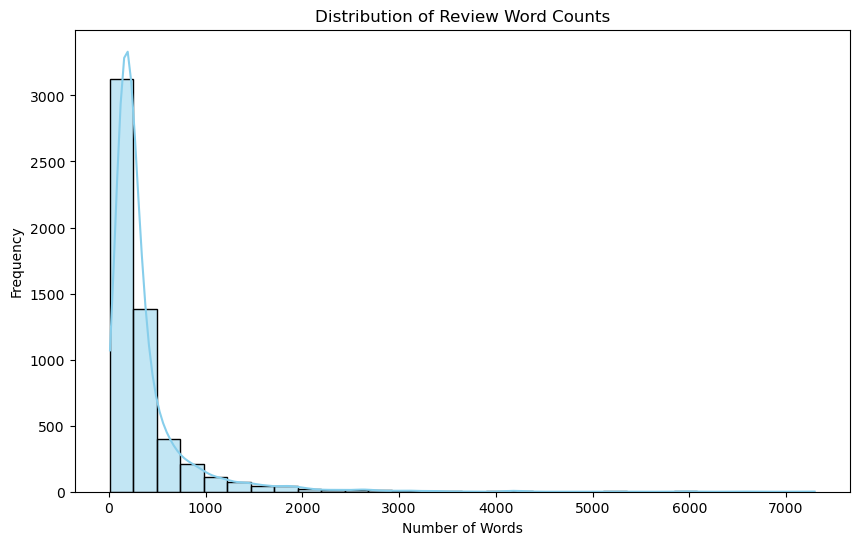

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import spacy
from wordcloud import WordCloud
import json

# Load the Portuguese model
nlp = spacy.load('pt_core_news_lg')

query_terms = [
    "Tesla", "carro elétrico", "Renault Zoe",
    "emissão zero",
    "mobilidade sustentável","poluição do ar" 
]

df_cleaned = pd.read_json('cleaned_articles_spacy6.json', orient='records', lines=True)

# df_cleaned = df_cleaned[df_cleaned['query_term'] == "emissão zero"]

df_cleaned['word_count'] = df_cleaned['tokens'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Review Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

<h2>Step 2: Box Plot of Word Counts</h2>

<p>Next, a box plot is generated to visualize the spread and identify any potential outliers in the word counts of the articles.</p>

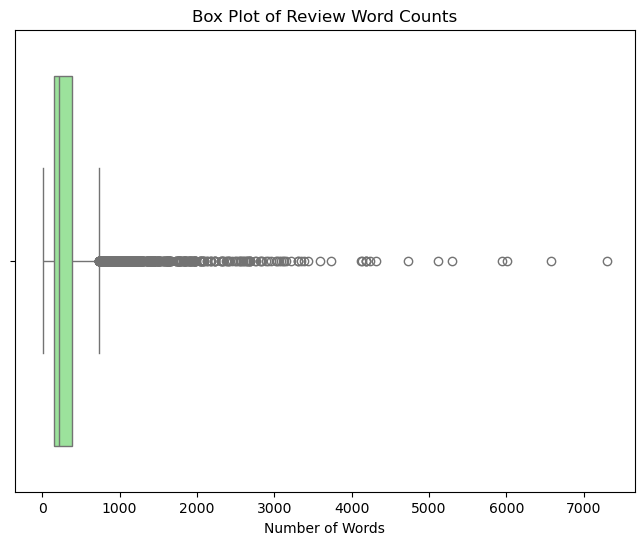

In [3]:
# Plot box plot
plt.figure(figsize=(8,6))
sns.boxplot(x=df_cleaned['word_count'], color='lightgreen')
plt.title('Box Plot of Review Word Counts')
plt.xlabel('Number of Words')
plt.show()

<h2>Step 3: Top 10 Most Frequently Occurring Words</h2>

<p>This visualization identifies the top 10 most frequent words across all articles. A bar plot is used to show the frequency of these words.</p>


C:\Users\FF\AppData\Local\Temp\ipykernel_22400\3944863060.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


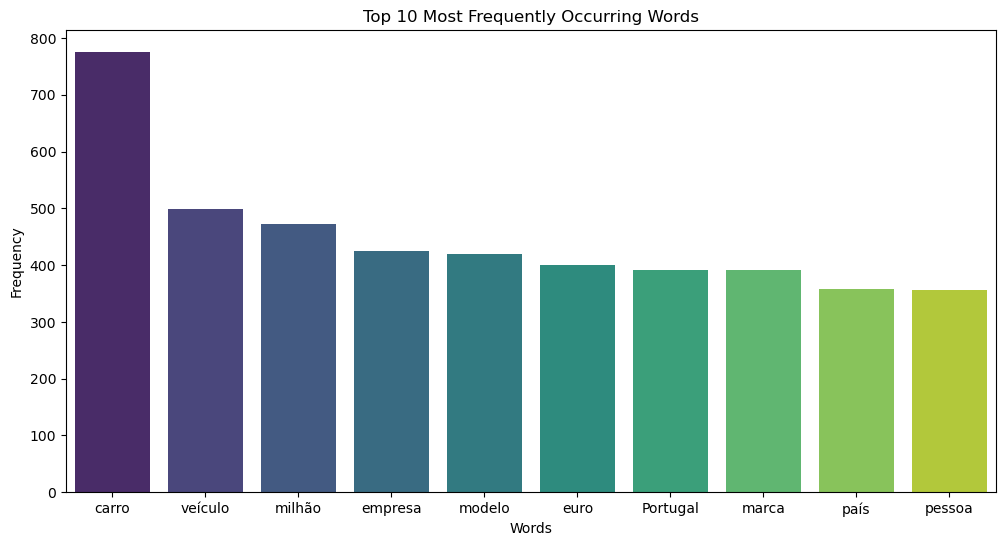

In [4]:
# 3. Top 10 Most Frequently Occurring Words

# Flatten tokens
all_tokens = [token for tokens in df_cleaned['keywords'] for token in tokens]
word_freq = Counter(all_tokens)
top_10_words = word_freq.most_common(10)
words, counts = zip(*top_10_words)

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('Top 10 Most Frequently Occurring Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

<h2>Step 4: Word Cloud of Most Frequent Words</h2>

<p>A word cloud is created to provide a visual representation of the most frequently occurring words, with word size corresponding to frequency.</p>

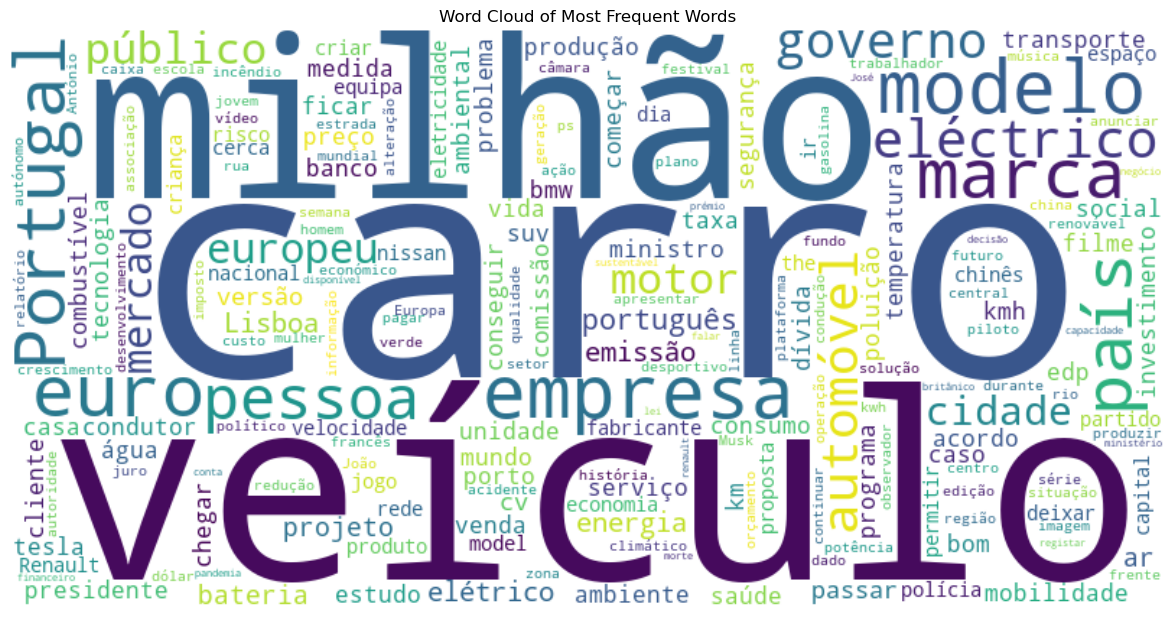

In [11]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

<h2>Step 5: Top 10 Bi-grams and Tri-grams</h2>

<p>This section extracts and visualizes the top 10 bi-grams and tri-grams (two and three consecutive words) from the article texts. These are useful for identifying common phrases and multi-word expressions.</p>

C:\Users\FF\AppData\Local\Temp\ipykernel_24832\1397613744.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigrams), y=list(bigram_counts), palette='magma')


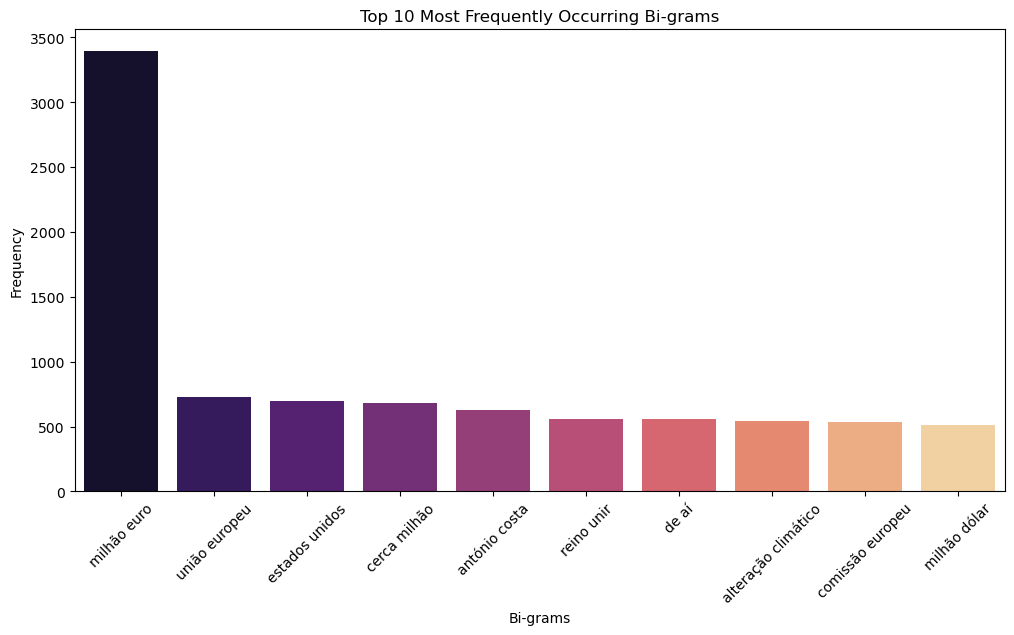

C:\Users\FF\AppData\Local\Temp\ipykernel_24832\1397613744.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(trigrams), y=list(trigram_counts), palette='coolwarm')


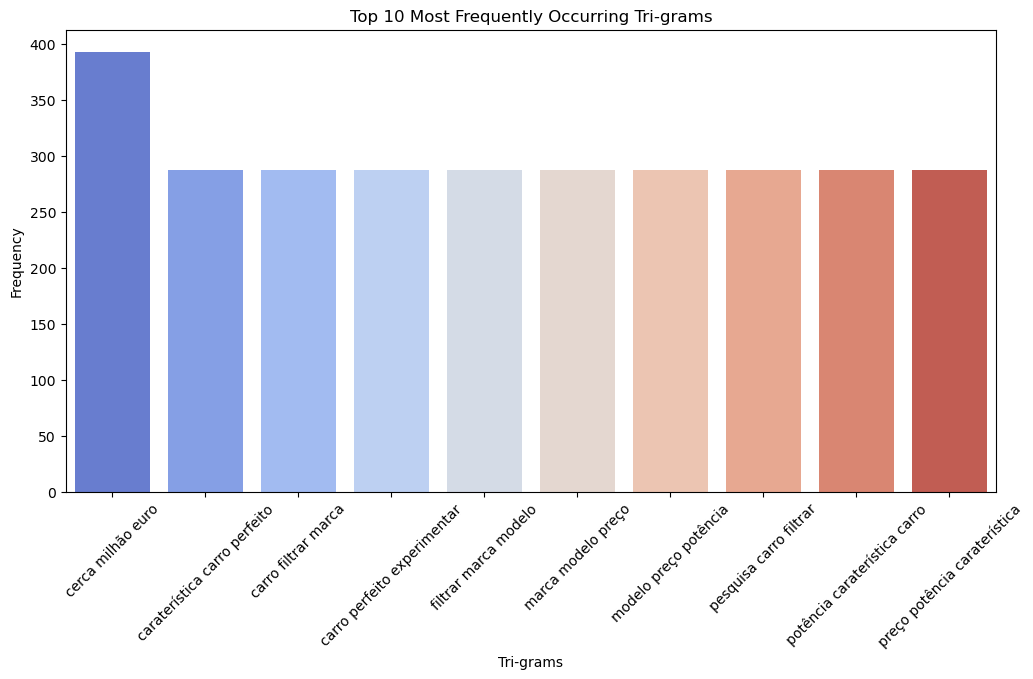

In [7]:
# 4. Top 10 Bi-grams and Tri-grams

# Join tokens back into strings
df_cleaned['cleaned_text_joined'] = df_cleaned['tokens'].apply(lambda x: ' '.join(x))

# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2,2), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None)
    X = vectorizer.fit_transform(corpus)
    sum_counts = X.sum(axis=0)
    counts = sum_counts.A1
    ngrams = vectorizer.get_feature_names_out()
    ngram_freq = zip(ngrams, counts)
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    return sorted_ngrams[:top_n]

# Top 10 Bi-grams
top_10_bigrams = get_top_ngrams(df_cleaned['cleaned_text_joined'], ngram_range=(2,2), top_n=10)
bigrams, bigram_counts = zip(*top_10_bigrams)

plt.figure(figsize=(12,6))
sns.barplot(x=list(bigrams), y=list(bigram_counts), palette='magma')
plt.title('Top 10 Most Frequently Occurring Bi-grams')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Top 10 Tri-grams
top_10_trigrams = get_top_ngrams(df_cleaned['cleaned_text_joined'], ngram_range=(3,3), top_n=10)
trigrams, trigram_counts = zip(*top_10_trigrams)

plt.figure(figsize=(12,6))
sns.barplot(x=list(trigrams), y=list(trigram_counts), palette='coolwarm')
plt.title('Top 10 Most Frequently Occurring Tri-grams')
plt.xlabel('Tri-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

<h2>Step 6: TF-IDF Score</h2>


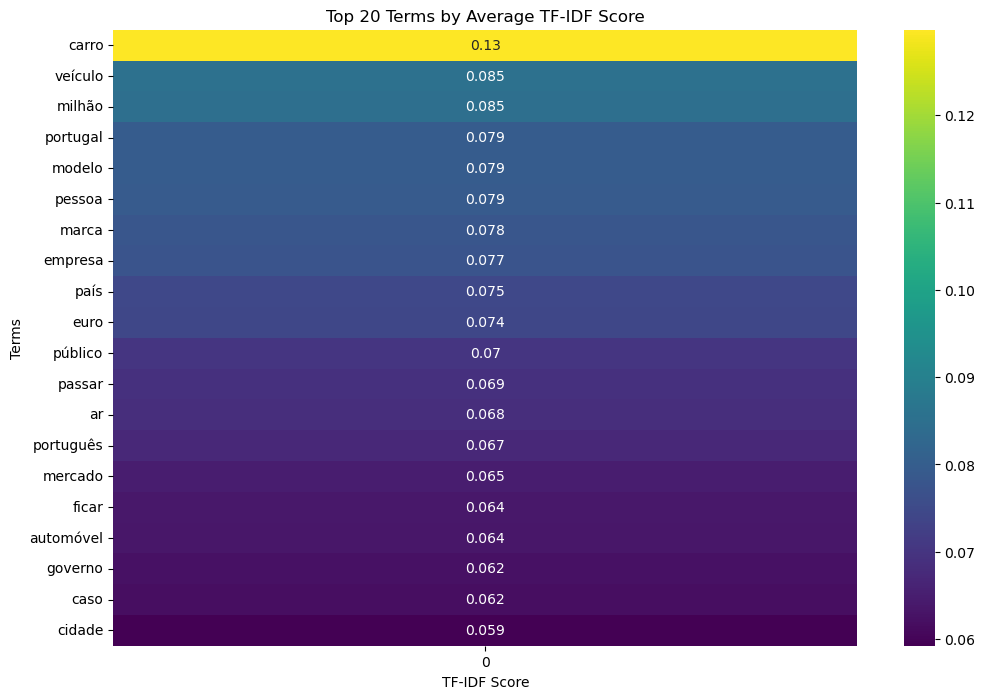

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=50)  # Adjust max_features as needed
tfidf_matrix = tfidf.fit_transform(df_cleaned['cleaned_text_joined'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Compute the average TF-IDF score for each term
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Select top N terms
top_n = 20
top_tfidf = avg_tfidf.head(top_n)

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_tfidf.to_frame(), annot=True, cmap='viridis')
plt.title('Top 20 Terms by Average TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Terms')
plt.show()



 <h2>Topic Modeling with LDA and Visualization</h2>
    <p><strong>Steps:</strong></p>
    <ol>
        <li>Load the custom stopwords from <code>stopwords.txt</code>.</li>
        <li>Read the cleaned articles from the JSON file: <code>cleaned_articles_spacy6.json</code>.</li>
        <li>Vectorize the text using <code>CountVectorizer</code> for LDA (or <code>TfidfVectorizer</code> for NMF).</li>
        <li>Fit the LDA model to find topics in the dataset.</li>
        <li>Display the top keywords per topic using a custom function.</li>
        <li>Add the dominant topic and its scores to the DataFrame.</li>
        <li>Visualize the topics using bar plots and a distribution plot.</li>
    </ol>

<h3>Step 1: Load Custom Stopwords</h3>
    <p>Load the custom stopwords from the <code>stopwords.txt</code> file. These will be used to filter out common, irrelevant words during text vectorization.</p>

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a custom list of stopwords in 'stopwords.txt'
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    custom_stopwords = [line.strip() for line in f]

<h3>Step 2: Load Cleaned Articles</h3>
    <p>Load the preprocessed and cleaned dataset from a JSON file. The file contains lemmatized text that will be analyzed.</p>

In [ ]:
input_file = "cleaned_articles_spacy3.json"
df_cleaned = pd.read_json(input_file, orient="records", lines=True)
print(f"Loaded {len(df_cleaned)} articles from {input_file}")

Loaded 10020 articles from cleaned_articles_spacy4.json


<h3>Step 3: Vectorize the Text</h3>
    <p>Transform the text data into a document-term matrix (DTM) using <code>CountVectorizer</code>. This matrix will be used as input to the LDA model.</p>

In [79]:
# Vectorize the text using CountVectorizer (for LDA) or TfidfVectorizer (for NMF)
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=custom_stopwords)  # Adjust parameters as neededs

# Transform the lemmatized text into a document-term matrix
dtm = vectorizer.fit_transform(df_cleaned['lemmatized_text'])

<h3>Step 4: Initialize and Fit the LDA Model</h3>
    <p>Set up the Latent Dirichlet Allocation (LDA) model and fit it to the document-term matrix. This will extract topics from the text data.</p>

In [98]:
# Initialize the LDA model
lda_model = LatentDirichletAllocation(n_components=3, random_state=42,learning_offset=40,max_iter=40)  # Adjust n_components for the number of topics

# Fit the LDA model
lda_model.fit(dtm)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

 <h3>Step 5: Display Topics and Keywords</h3>
    <p>Use the LDA model to extract and display the top keywords for each topic.</p>

In [99]:
# Function to display topics and their keywords
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the topics
display_topics(lda_model ,feature_names, no_top_words=10)

Topic 0:
euro, milhão, governo, público, banco, portugal, empresa, país, europeu, português
Topic 1:
pessoa, empresa, cidade, portugal, lisboa, país, elétrico, energia, projeto, português
Topic 2:
carro, marca, modelo, veículo, passar, motor, eléctrico, ficar, começar, automóvel


<h3>Step 6: Add Dominant Topics to DataFrame</h3>
    <p>Transform the document-topic distributions into a format that assigns the dominant topic and topic scores to each article.</p>

In [100]:
# Transform the documents to topic distributions
topic_distributions = lda_model.transform(dtm)

# Add the dominant topic to the dataframe
df_cleaned['dominant_topic'] = topic_distributions.argmax(axis=1)

# Optionally, add the probability scores for each topic
df_cleaned['topic_scores'] = topic_distributions.tolist()

# Save the DataFrame with topic assignments
df_cleaned.to_json('articles_with_topics.json', orient='records', lines=True, force_ascii=False)


<h3>Step 7: Visualize Topics</h3>
    <p>Create bar plots to visualize the top keywords for each topic and their associated weights.</p>

C:\Users\FF\AppData\Local\Temp\ipykernel_28132\2506710280.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=top_features, palette='viridis')


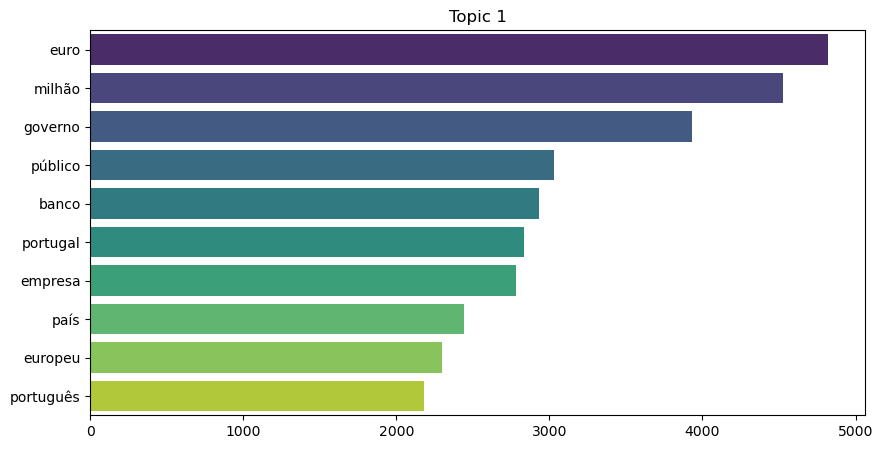

C:\Users\FF\AppData\Local\Temp\ipykernel_28132\2506710280.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=top_features, palette='viridis')


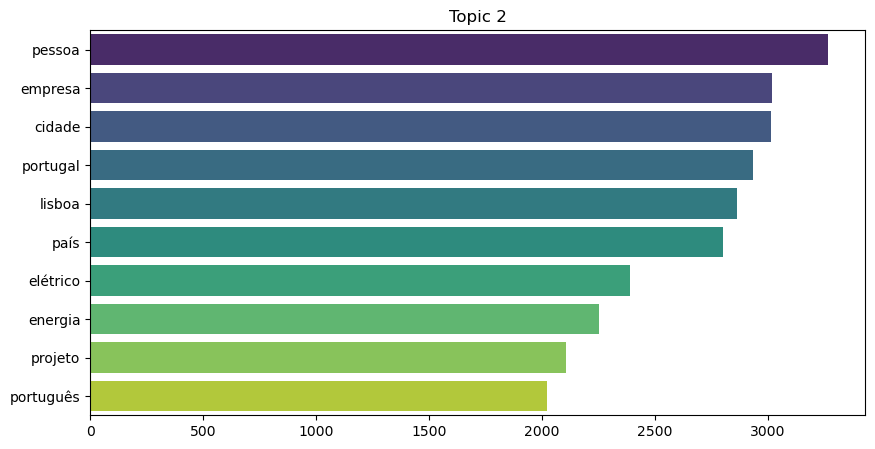

C:\Users\FF\AppData\Local\Temp\ipykernel_28132\2506710280.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=top_features, palette='viridis')


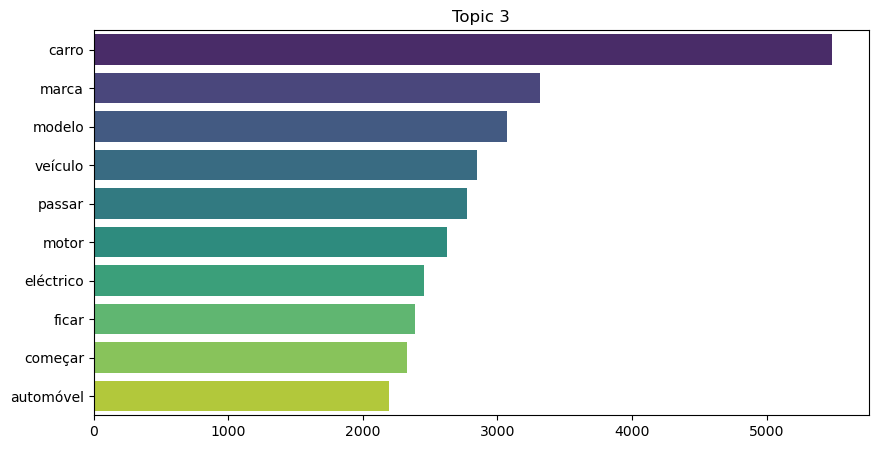

C:\Users\FF\AppData\Local\Temp\ipykernel_28132\2506710280.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='dominant_topic', palette='viridis')


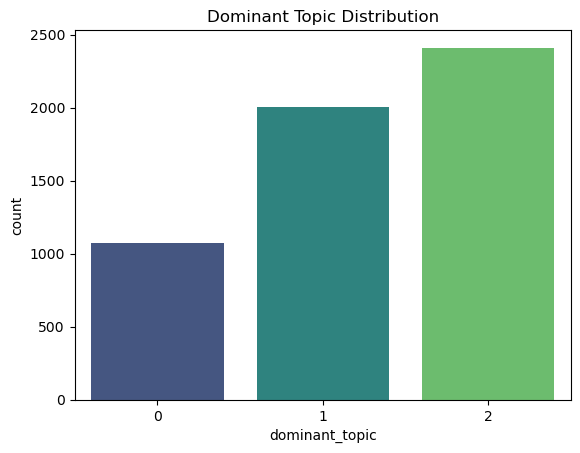

In [101]:
# Visualize the top words per topic
for topic_idx, topic in enumerate(lda_model.components_):  # Or use nmf_model for NMF
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=weights, y=top_features, palette='viridis')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()

# Plot the distribution of dominant topics
sns.countplot(data=df_cleaned, x='dominant_topic', palette='viridis')
plt.title("Dominant Topic Distribution")
plt.show()





## Sentiment Analysis on a Subset of the Dataset

In this step, I extracted a random subset of 500 articles from the larger dataset for focused sentiment analysis. The purpose was to efficiently analyze and verify sentiment using TextBlob, which is a tool that provides polarity and subjectivity scores for text.

### Key Points:
1. **Subset Extraction**:
   - A subset of 500 articles was randomly selected using `sample()` to ensure a manageable dataset size.
   - This allowed for a quicker analysis and manual verification of results.

2. **Sentiment Analysis**:
   - Since TextBlob does not have native support for Portuguese sentiment analysis, it was applied to the dataset. However, the polarity scores provided by TextBlob are language-agnostic.
   - Sentiment was classified as:
     - Positive (Polarity > 0) → Labelled as `1`.
     - Negative (Polarity <= 0) → Labelled as `0`.

3. **Manual Verification**:
   - Given the limitations of TextBlob's non-Portuguese support, I manually reviewed and verified the sentiment labels for accuracy.

4. **Output**:
   - The results were saved in a new file called `subset_with_sentiment.json`, containing columns:
     - `sentiment` (Sentiment label: Positive = 1, Negative = 0)
     - `cleaned_title` (Title of the article)
     - `cleaned_text` (Full article text)
   - This subset can be used for further analysis or as a baseline for training and evaluating other sentiment analysis models.

In [6]:
import pandas as pd
from textblob import TextBlob

# Load the dataset
input_file = "cleaned_articles_spacy6.json"
df_cleaned = pd.read_json(input_file, orient="records", lines=True)
print(f"Loaded {len(df_cleaned)} articles from {input_file}")

# Drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=['relevance_score', 'tokens'])

# Create a subset of 500 articles
subset = df_cleaned.sample(n=500, random_state=42)
# Custom function for Portuguese sentiment analysis
def analyze_sentiment_pt(text):
    blob = TextBlob(text)
    # Use polarity for sentiment classification
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity 
    return 1 if polarity > 0 else 0  # Positive = 1, Negative = 0

# Apply to your dataset
subset['sentiment'] = subset['lemmatized_text'].apply(analyze_sentiment_pt)
print(subset[['lemmatized_text', 'sentiment']].head())


subset_to_save = subset[['sentiment', 'cleaned_title', 'cleaned_text']]
# Save the subset with sentiment labels
output_file = "subset_with_sentiment.json"
subset_to_save.to_json(output_file, orient="records", lines=True, force_ascii=False)


Loaded 5487 articles from cleaned_articles_spacy6.json
                                        lemmatized_text  sentiment
1468  caixa depósito cgd decidir vender participação...          0
33    surfar mar tá flat diálogo ouvir habitante vil...          0
8     saber empresa contratar associação mutualista ...          1
3755  capítulo ii besta monstro desembarcar Lisboa b...          0
889   audi acabar revelar facelift preparar geração ...          0


## Fine-Tuning BERTimbau for Sentiment Analysis

In this step, after doing the manual sentiment analysis, I fine-tuned the BERTimbau model (`neuralmind/bert-base-portuguese-cased`) for binary sentiment classification on the subset of articles with labeled sentiment data. The process involves preparing the dataset, tokenizing the text, and using the Hugging Face `Trainer` API to fine-tune the model.

### Steps:

1. **Loading the Dataset**:
   - The labeled sentiment dataset (`subset_with_sentiment.json`) was loaded. The labels represent:
     - `1` for positive sentiment.
     - `0` for negative sentiment.

2. **Data Splitting**:
   - The data was split into 80% training and 20% validation sets using `train_test_split` for robust evaluation.

3. **Tokenization**:
   - The `BertTokenizer` from the pre-trained `BERTimbau` model was used to tokenize the text.
   - Text was truncated or padded to a maximum length of 512 tokens (BERT's limit).
   - Tokenized data was converted into PyTorch tensors for compatibility with the model.

4. **Dataset Preparation**:
   - A custom PyTorch dataset class (`SentimentDataset`) was created to handle the tokenized encodings and corresponding sentiment labels.

5. **Model Initialization**:
   - The `BERTimbau` model (`neuralmind/bert-base-portuguese-cased`) was loaded, configured for sequence classification with two output labels (positive and negative sentiment).

6. **Training Arguments**:
   - The following training parameters were defined using `TrainingArguments`:
     - Batch size: 8 (per device for training and evaluation).
     - Gradient accumulation steps: 2 (to effectively double the batch size without increasing memory usage).
     - Learning rate: `1e-5` with weight decay for regularization.
     - Logging: Enabled for every 10 steps.
     - Number of epochs: 5.

7. **Metrics**:
   - The accuracy metric was computed using predictions from the validation dataset.

8. **Trainer API**:
   - The Hugging Face `Trainer` API was used to streamline the fine-tuning process. It handles model training, evaluation, and logging seamlessly.

9. **Fine-Tuning**:
   - The model was fine-tuned on the training dataset, with validation occurring at the end of each epoch.

### Output:
- The fine-tuned model is stored in the `./results` directory, and training logs are available in the `./logs` directory.
- The fine-tuned model can be used for downstream tasks or deployed for sentiment analysis in Portuguese text.



In [6]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

# Load your labeled dataset
data = pd.read_json("subset_with_sentiment.json", orient="records", lines=True) 
print(data['sentiment'].value_counts())


# Split into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["cleaned_text"].tolist(),
    data["sentiment"].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize text using BERTimbau's tokenizer
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"  # Ensures proper tensor format
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Ensure train_encodings and val_encodings are dictionaries
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Load BERTimbau model
model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=2)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",         # Directory for model checkpoints
    eval_strategy="epoch",          # Use updated argument
    learning_rate=1e-5,
    per_device_train_batch_size=8,  # Reduced batch size for limited GPU memory
    gradient_accumulation_steps=2, # Accumulate gradients for 2 steps
    max_grad_norm=1.0,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",           # Directory for logs
    logging_steps=10,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

sentiment
0    273
1    227
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/125 [00:00<?, ?it/s]

C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6995, 'grad_norm': 3.0737123489379883, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.4}
{'loss': 0.6789, 'grad_norm': 3.144216537475586, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.8}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6666861772537231, 'eval_accuracy': 0.58, 'eval_runtime': 60.1724, 'eval_samples_per_second': 1.662, 'eval_steps_per_second': 0.216, 'epoch': 1.0}


C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6586, 'grad_norm': 3.105973482131958, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.2}
{'loss': 0.6478, 'grad_norm': 2.991018772125244, 'learning_rate': 6.800000000000001e-06, 'epoch': 1.6}
{'loss': 0.6132, 'grad_norm': 5.287275791168213, 'learning_rate': 6e-06, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.6242355704307556, 'eval_accuracy': 0.68, 'eval_runtime': 64.2418, 'eval_samples_per_second': 1.557, 'eval_steps_per_second': 0.202, 'epoch': 2.0}


C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.5809, 'grad_norm': 3.993492841720581, 'learning_rate': 5.2e-06, 'epoch': 2.4}
{'loss': 0.5895, 'grad_norm': 5.124366760253906, 'learning_rate': 4.4e-06, 'epoch': 2.8}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.5990829467773438, 'eval_accuracy': 0.72, 'eval_runtime': 51.257, 'eval_samples_per_second': 1.951, 'eval_steps_per_second': 0.254, 'epoch': 3.0}


C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.6032, 'grad_norm': 4.205565929412842, 'learning_rate': 3.6000000000000003e-06, 'epoch': 3.2}
{'loss': 0.5755, 'grad_norm': 10.910710334777832, 'learning_rate': 2.8000000000000003e-06, 'epoch': 3.6}
{'loss': 0.5306, 'grad_norm': 4.248270034790039, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.5879878401756287, 'eval_accuracy': 0.71, 'eval_runtime': 51.534, 'eval_samples_per_second': 1.94, 'eval_steps_per_second': 0.252, 'epoch': 4.0}


C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.5505, 'grad_norm': 4.793732166290283, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.4}
{'loss': 0.5168, 'grad_norm': 5.245857238769531, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.8}


C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.5868108868598938, 'eval_accuracy': 0.69, 'eval_runtime': 52.6481, 'eval_samples_per_second': 1.899, 'eval_steps_per_second': 0.247, 'epoch': 5.0}
{'train_runtime': 4101.067, 'train_samples_per_second': 0.488, 'train_steps_per_second': 0.03, 'train_loss': 0.6003227844238281, 'epoch': 5.0}


TrainOutput(global_step=125, training_loss=0.6003227844238281, metrics={'train_runtime': 4101.067, 'train_samples_per_second': 0.488, 'train_steps_per_second': 0.03, 'total_flos': 526222110720000.0, 'train_loss': 0.6003227844238281, 'epoch': 5.0})

## Evaluating and Saving the Fine-Tuned Model

After completing the fine-tuning process, the model was evaluated on the validation dataset to measure its performance. The evaluation results provide insights into how well the model generalizes to unseen data.

### Steps:

1. **Model Evaluation**:
   - The `trainer.evaluate()` method was used to compute metrics on the validation dataset.
   - Accuracy was the primary metric used to assess the model's performance.
   - The evaluation results are printed to provide a quick summary of the model's effectiveness.

2. **Saving the Fine-Tuned Model**:
   - The fine-tuned model and its tokenizer were saved to the `./bertimbau-sentiment` directory for future use.
   - Saving both the model and tokenizer ensures that the exact configuration and tokenization logic used during training can be reloaded later for inference or further fine-tuning.

### Output:
- The evaluation results (e.g., accuracy) give an indication of the model's sentiment classification performance.
- The saved model and tokenizer can now be reused for:
  - Sentiment analysis on new Portuguese text.
  - Deployment in production environments.
  - Further experimentation or fine-tuning on related tasks.

In [7]:
# Evaluate the model
results = trainer.evaluate()
print(results)

model.save_pretrained("./bertimbau-sentiment")
tokenizer.save_pretrained("./bertimbau-sentiment")


C:\Users\FF\AppData\Local\Temp\ipykernel_28132\4109462237.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.5868108868598938, 'eval_accuracy': 0.69, 'eval_runtime': 57.24, 'eval_samples_per_second': 1.747, 'eval_steps_per_second': 0.227, 'epoch': 5.0}


('./bertimbau-sentiment\\tokenizer_config.json',
 './bertimbau-sentiment\\special_tokens_map.json',
 './bertimbau-sentiment\\vocab.txt',
 './bertimbau-sentiment\\added_tokens.json')

## Model Performance Evaluation with Classification Report

To evaluate the fine-tuned BERTimbau model's performance on sentiment classification, a detailed classification report was generated. This includes precision, recall, F1-score, and support metrics for each sentiment class.

### Steps:

1. **Dataset Preparation**:
   - The test dataset was converted to a Hugging Face `Dataset` format from a Pandas DataFrame.
   - The `cleaned_text` column was tokenized using the same tokenizer (`BERTimbau tokenizer`) applied during training, ensuring consistency in preprocessing.
   - Tokenization involved:
     - Truncating and padding to a maximum length of 512 tokens.
     - Adding attention masks for BERT's input requirements.
   - Non-required columns (e.g., original text) were removed from the dataset to streamline predictions.

2. **Prediction**:
   - The `trainer.predict()` method was used to generate predictions on the test dataset.
   - The predicted class labels were determined by taking the `argmax` of the logits output.

3. **Classification Report**:
   - The `sklearn.metrics.classification_report` function was used to evaluate the predictions against the true labels.
   - Metrics provided:
     - **Precision**: Proportion of true positive predictions among all positive predictions.
     - **Recall**: Proportion of true positive predictions among all actual positive cases.
     - **F1-Score**: Harmonic mean of precision and recall.
     - **Support**: Number of true instances for each class.
   - Sentiment classes were labeled as:
     - `Negative` = 0.
     - `Positive` = 1.

### Output:
- The classification report provides a comprehensive breakdown of the model's performance on each class (positive and negative sentiment).
- It highlights areas where the model performs well and areas where it might need improvement.

In [14]:
from sklearn.metrics import classification_report

data.head()
test_dataset = Dataset.from_pandas(data)

# Tokenize the text column in the dataset
test_dataset = test_dataset.map(
    lambda e: tokenizer(e["cleaned_text"], truncation=True, padding="max_length", max_length=512),
    batched=True
)

# Remove columns not needed by the model (e.g., original text)
test_dataset = test_dataset.remove_columns(["cleaned_text"])

predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=-1)

true_labels = test_dataset["sentiment"] # Replace with the correct label column
print(classification_report(true_labels, preds, target_names=["Negative", "Positive"]))


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

  0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.72      0.84      0.78       273
    Positive       0.76      0.61      0.68       227

    accuracy                           0.74       500
   macro avg       0.74      0.73      0.73       500
weighted avg       0.74      0.74      0.73       500



In [15]:
input_file = "cleaned_articles_spacy6.json"
df_cleaned = pd.read_json(input_file, orient="records", lines=True)

# Keep only necessary columns
df_cleaned = df_cleaned[["cleaned_text"]]  # Adjust column name as needed
print(f"Loaded {len(df_cleaned)} articles for labeling")

Loaded 5487 articles for labeling


In [16]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained("./bertimbau-sentiment")
tokenizer = BertTokenizer.from_pretrained("./bertimbau-sentiment")

In [17]:
def predict_sentiment_with_confidence(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    prediction = torch.argmax(logits, dim=1).item()
    return {
        "sentiment": "Positive" if prediction == 1 else "Negative",
        "confidence_positive": probabilities[1],
        "confidence_negative": probabilities[0],
    }

# Apply with confidence
df_cleaned["sentiment_with_confidence"] = df_cleaned["cleaned_text"].apply(predict_sentiment_with_confidence)

In [19]:
output_file = "labeled_articles.csv"
df_cleaned.to_csv(output_file, index=False, encoding="utf-8")
print(f"Labeled dataset saved to {output_file}")
df_cleaned.to_json('labeled_articles.json', orient='records', lines=True, force_ascii=False)

Labeled dataset saved to labeled_articles.csv


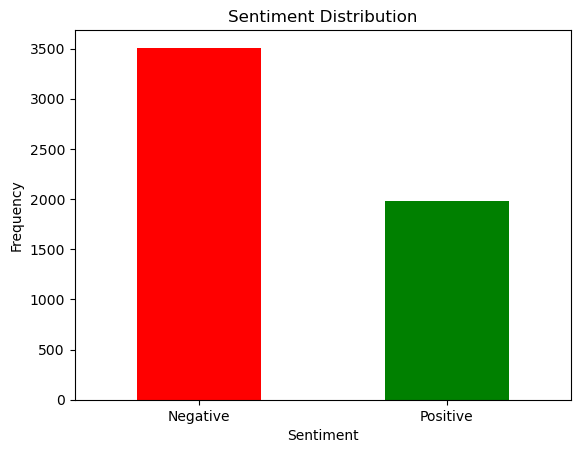

In [70]:
import matplotlib.pyplot as plt

df_cleaned = pd.read_json('labeled_articles.json', orient='records', lines=True)

# Count sentiment predictions
sentiment_counts = df_cleaned["sentiment_with_confidence"].apply(lambda x: x["sentiment"]).value_counts()

# Plot the distribution
sentiment_counts.plot(kind="bar", color=["red", "green"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

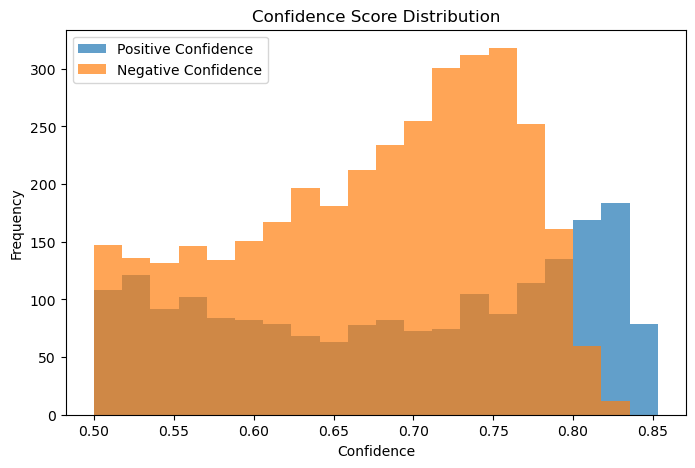

In [73]:
def extract_confidence_values(row):
    sentiment = row["sentiment_with_confidence"]["sentiment"]
    if sentiment == "Positive":
        return {"confidence_positive": row["sentiment_with_confidence"]["confidence_positive"], 
                "confidence_negative": None}
    else:
        return {"confidence_positive": None, 
                "confidence_negative": row["sentiment_with_confidence"]["confidence_negative"]}

# Apply the logic to each row
confidence_values = df_cleaned.apply(extract_confidence_values, axis=1)

# Split the result into two separate columns
df_cleaned["confidence_positive"] = confidence_values.apply(lambda x: x["confidence_positive"])
df_cleaned["confidence_negative"] = confidence_values.apply(lambda x: x["confidence_negative"])

# Plot confidence score distribution
df_cleaned[["confidence_positive", "confidence_negative"]].plot(kind="hist", bins=20, alpha=0.7, figsize=(8, 5))
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.legend(["Positive Confidence", "Negative Confidence"])
plt.show()

In [68]:
from sklearn.metrics import classification_report

# Load your labeled dataset
subset = pd.read_json("subset_with_sentiment.json", orient="records", lines=True)

# Merge on cleaned_text to align true sentiments with the full dataset
df_cleaned = df_cleaned.merge(subset[["cleaned_text", "sentiment"]], on="cleaned_text", how="left")

# Rename the true sentiment column for clarity
df_cleaned.rename(columns={"sentiment": "true_sentiment"}, inplace=True)

# Filter rows with true_sentiment for evaluation
df_evaluation = df_cleaned[df_cleaned["true_sentiment"].notna()]

# Convert model predictions to binary labels
predictions = df_evaluation["sentiment_with_confidence"].apply(lambda x: 1 if x["sentiment"] == "Positive" else 0)

# Generate the classification report
print(classification_report(df_evaluation["true_sentiment"].astype(int), predictions))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       300
           1       0.77      0.61      0.68       231

    accuracy                           0.75       531
   macro avg       0.75      0.73      0.73       531
weighted avg       0.75      0.75      0.74       531



Total misclassified: 134
                                           cleaned_text  true_sentiment  \
33    surfamos hoje não que o mar tá flat ora aí est...             1.0   
65    há uma música da ala dos namorados chamada a h...             1.0   
107   muito provavelmente nunca ouviu falar do carro...             0.0   
230   os termómetros têm andado a bater os graus dia...             1.0   
240   título a europa à deriva autor slavoj zizek ed...             1.0   
...                                                 ...             ...   
5266  a mit technology review revista do instituto d...             1.0   
5329  o campeonato do mundo de f arrancou normalment...             1.0   
5443  o centro colombo em lisboa investiu no reforço...             1.0   
5456  a worten contribui para que esta informação es...             1.0   
5484  o universo anf de associação a grupo económico...             1.0   

                              sentiment_with_confidence  
33    {'sentimen

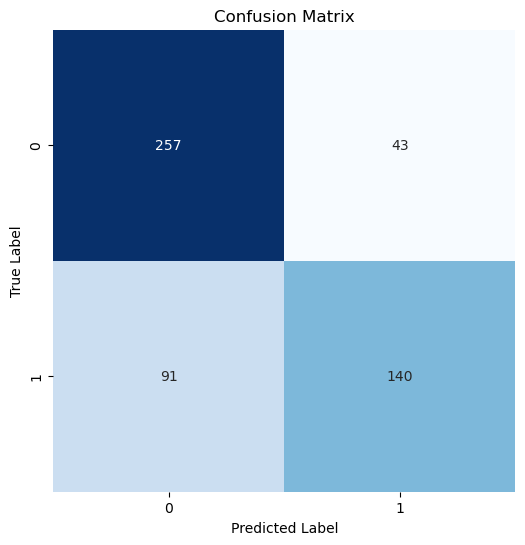

In [76]:
misclassified = df_evaluation[df_evaluation["true_sentiment"] != predictions]
print(f"Total misclassified: {len(misclassified)}") 
print(misclassified[["cleaned_text", "true_sentiment", "sentiment_with_confidence"]])
misclassified.to_json('misclassified.json', orient='records', lines=True, force_ascii=False)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(df_evaluation["true_sentiment"].astype(int), predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

